In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv("C:\portfolio\promo-pairs-margin-ranking\data\products.csv")

In [4]:
print("\nИнформация о столбцах:")
print(df.info())
print("\nПропуски:")
print(df.isnull().sum())



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  30000 non-null  int64 
 1   CustomerID     30000 non-null  object
 2   Products       30000 non-null  object
 3   Timestamp      30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB
None

Пропуски:
TransactionID    0
CustomerID       0
Products         0
Timestamp        0
dtype: int64


In [5]:
print("Столбцы:", df.columns.tolist())
print("\nУникальные TransactionID:", df['TransactionID'].nunique())
print("\nПример продуктов:", df['Products'].iloc[0])

Столбцы: ['TransactionID', 'CustomerID', 'Products', 'Timestamp']

Уникальные TransactionID: 30000

Пример продуктов: Dish Sponge, Flatbread with Meat, Chips, Orange, Butter, Sausage, Cucumber, Rice, Ice Cream


In [6]:
from itertools import combinations
import pandas as pd

df['product_list'] = df['Products'].str.split(', ')

df['basket_size'] = df['product_list'].str.len()
print("Размер корзины (статистика):")
print(df['basket_size'].describe())

def get_pairs_from_basket(basket):
    """Генерирует все возможные пары товаров из корзины."""
    if len(basket) < 2:
        return []
    return list(combinations(sorted(basket), 2))

df['pairs'] = df['product_list'].apply(get_pairs_from_basket)

pairs_df = df.explode('pairs').dropna(subset=['pairs']).reset_index(drop=True)
pairs_df[['item1', 'item2']] = pd.DataFrame(pairs_df['pairs'].tolist(), index=pairs_df.index)

pairs_df = pairs_df[['TransactionID', 'CustomerID', 'item1', 'item2']].copy()

print("\nПары созданы! Размер:", pairs_df.shape)
print("\nПервые пары:")
pairs_df.head()

Размер корзины (статистика):
count    30000.000000
mean         6.583633
std          2.332464
min          3.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         11.000000
Name: basket_size, dtype: float64

Пары созданы! Размер: (633012, 4)

Первые пары:


,TransactionID,CustomerID,item1,item2
0,1,C546,Butter,Chips
1,1,C546,Butter,Cucumber
2,1,C546,Butter,Dish Sponge
3,1,C546,Butter,Flatbread with Meat
4,1,C546,Butter,Ice Cream


In [7]:
pair_metrics = (
    pairs_df.groupby(['item1', 'item2'])
    .agg(
        pair_count=('TransactionID', 'size'),
        transactions=('TransactionID', 'nunique')
    )
    .reset_index()
)

total_transactions = df['TransactionID'].nunique()

pair_metrics['frequency_pct'] = (pair_metrics['transactions'] / total_transactions * 100).round(2)

print("Топ-10 самых частых пар:")
top_pairs = pair_metrics.nlargest(10, 'transactions')
print(top_pairs)

print(f"\nВсего уникальных пар: {len(pair_metrics):,}")

Топ-10 самых частых пар:
      item1      item2  pair_count  transactions  frequency_pct
204  Cereal       Milk        2852          2852           9.51
185  Cereal     Cheese        1192          1192           3.97
214  Cereal       Soda        1182          1182           3.94
201  Cereal  Ice Cream        1177          1177           3.92
189  Cereal  Chocolate        1168          1168           3.89
202  Cereal      Juice        1167          1167           3.89
150  Butter     Cereal        1162          1162           3.87
79    Beans     Cereal        1160          1160           3.87
193  Cereal   Cucumber        1158          1158           3.86
198  Cereal       Fish        1156          1156           3.85

Всего уникальных пар: 780


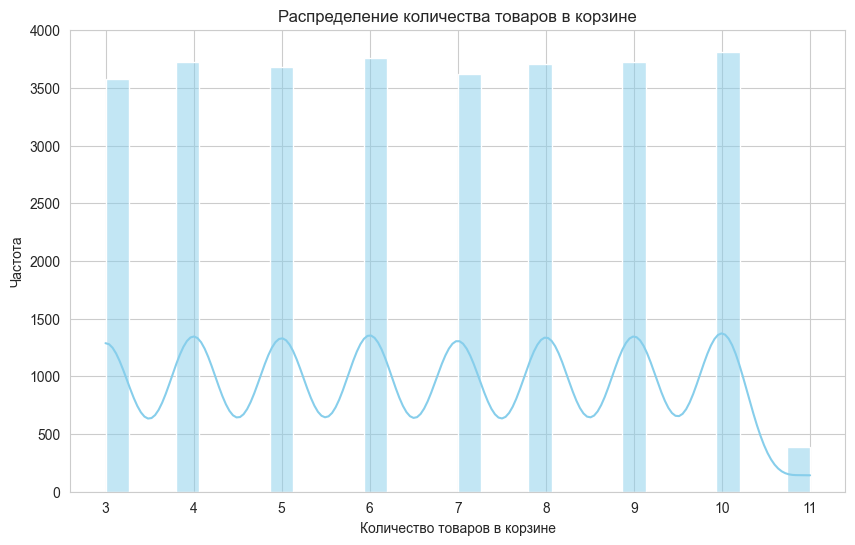

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['basket_size'], bins=30, kde=True, color='skyblue')
plt.title("Распределение количества товаров в корзине")
plt.xlabel("Количество товаров в корзине")
plt.ylabel("Частота")
plt.show()

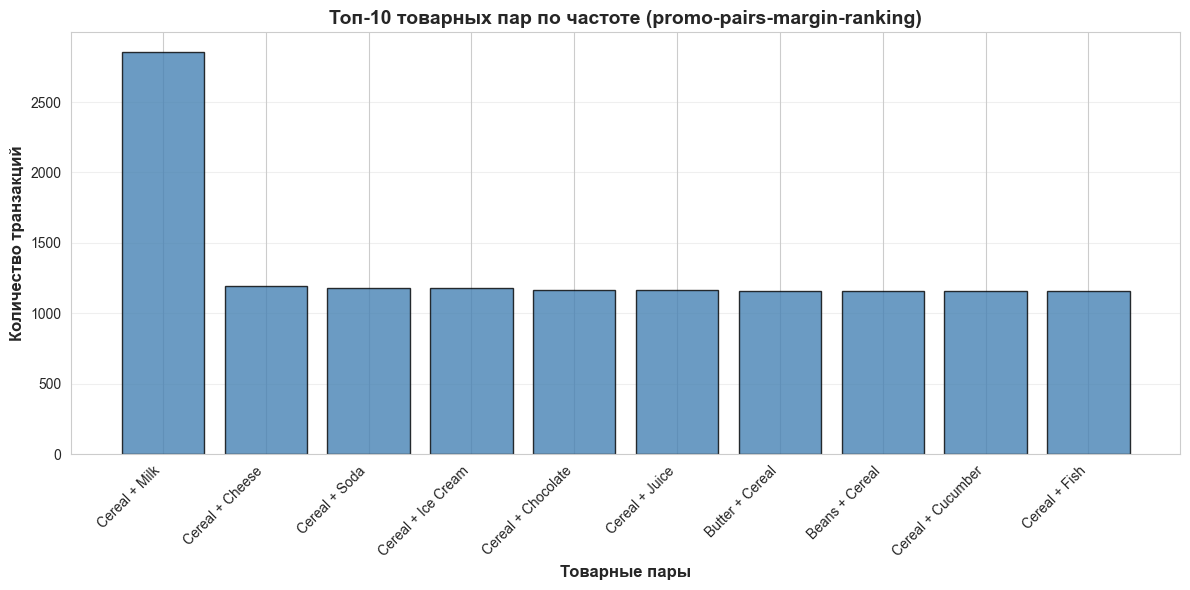

In [9]:
top10_pairs = (
    pair_metrics
    .sort_values('transactions', ascending=False)
    .head(10)
)

top10_pairs['pair_name'] = top10_pairs['item1'] + ' + ' + top10_pairs['item2']

plt.figure(figsize=(12, 6))
plt.bar(top10_pairs['pair_name'], top10_pairs['transactions'], color='steelblue', edgecolor='black', alpha=0.8)

plt.xlabel('Товарные пары', fontsize=12, fontweight='bold')
plt.ylabel('Количество транзакций', fontsize=12, fontweight='bold')
plt.title('Топ-10 товарных пар по частоте (promo-pairs-margin-ranking)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()